# Learning PyTorch

## Identity Function

In [1]:
%matplotlib inline
from random import choice, randrange
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import random

EOS = "<EOS>" #all strings will end with the End Of String token
PAD = "<PAD>"
characters = list("abcd")
characters.append(EOS)
characters.append(PAD)

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-2]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    #return random_string, random_string[::-1]  # Return the random string and its reverse
    return random_string, random_string

MAX_STRING_LEN = 15
batch_size = 100

train_set = [sample_model(1, MAX_STRING_LEN) for _ in range(3000)]
val_set = [sample_model(1, MAX_STRING_LEN) for _ in range(50)]

## PyTorch

In [2]:
#some helper functions
def _preprocess_string(strings):
    strings_with_eos = [list(string) + [EOS] for string in strings]
    max_len = max([len(string) for string in strings_with_eos])
    padded_strings = [string+[PAD]*(max_len-len(string)) for string in strings_with_eos]
    int_strings = [[char2int[c] for c in string] for string in padded_strings]
    transposed = [[int_strings[j][i] for j in range(len(strings))] for i in range(max_len)]
    return Variable(torch.LongTensor(transposed))

def get_loss(network, input_strings, output_strings):
    batch_size = len(output_strings)
    input_strings = _preprocess_string(input_strings)
    output_strings = _preprocess_string(output_strings)

    probs = network(input_strings, batch_size)
    
    loss = sum([F.nll_loss(p, t) for p, t in zip(probs, output_strings)])
    return loss

def generate(network, input_string):
    input_string = _preprocess_string([input_string])
    probs = network(input_string, 1)
    generated = [int2char[prob[0].topk(1)[1][0]] for prob in probs.data]
    return (''.join(generated)).split(EOS)[0].replace(PAD, '')


In [31]:
def train(network, train_set, val_set, epochs = 30):
    def get_val_set_loss(network, val_set):
        losses = []
        
        input_strings = []
        output_strings = []
    
        for i in range(len(val_set)):
            input_string, output_string = val_set[i]
            input_strings.append(input_string)
            output_strings.append(output_string)
            if i%batch_size == 0:
                loss = get_loss(network, input_strings, output_strings).data[0]
                losses.append(loss)
                
                input_strings = []
                output_strings = []
        if input_strings:
            loss = get_loss(network, input_strings, output_strings).data[0]
            losses.append(loss)
        return sum(losses)
    
    train_set = train_set*epochs
    random.shuffle(train_set)
    losses = []
    iterations = []

    optim = torch.optim.SGD(network.parameters(), lr = 0.05, momentum=0.9)
    
    input_strings = []
    output_strings = []
    for i in tqdm(range(len(train_set))):
        
        input_string, output_string = train_set[i]
        input_strings.append(input_string)
        output_strings.append(output_string)
        if i%batch_size == 0:
            optim.zero_grad()
            loss = get_loss(network, input_strings, output_strings)
            loss_value = loss.data[0]
            loss.backward()
            optim.step()
            
            input_strings = []
            output_strings = []

        # Accumulate average losses over training to plot
        if i%(len(train_set)/100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i/((len(train_set)/100)))

    plt.plot(iterations, losses)
    #plt.axis([0, 100, 0, 100])
    plt.show() 
    print('loss on validation set:', val_loss)

In [8]:
class SimpleRNNNetwork(nn.Module):
    def __init__(self,num_of_layers, embeddings_size, state_size):
        super(SimpleRNNNetwork, self).__init__()
        self.num_of_layers = num_of_layers
        self.state_size = state_size
        
        # the embedding paramaters
        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size)

        # the rnn
        self.RNN = nn.LSTM(embeddings_size, state_size, num_of_layers)
        
        # project the rnn output to a vector of VOCAB_SIZE length
        self.linear = nn.Linear(state_size, VOCAB_SIZE)    
    def lstm_init_func(self, batch_size):
        h0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        c0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        return h0,c0
    def __call__(self, input_string, batch_size):                        
        embedded = self.embeddings(input_string)
        output, hn = self.RNN(embedded, self.rnn_init_func(self, batch_size))
        logits = self.linear(output)
        return F.log_softmax(logits, 2)   

### LSTM

100%|██████████| 90000/90000 [01:17<00:00, 1167.11it/s]


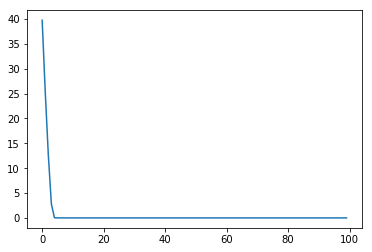

loss on validation set: 0.00020737617887789384
abc


In [9]:
RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
STATE_SIZE = 128

lstm_net = SimpleRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(lstm_net, train_set, val_set)
print(generate(lstm_net, 'abc'))

## encoder-decoder

In [32]:
class EncoderDecoderNetwork(nn.Module):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(EncoderDecoderNetwork, self).__init__()
        self.num_of_layers = num_of_layers
        self.state_size = state_size
        
        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size)

        self.enc = nn.LSTM(embeddings_size, state_size, num_of_layers)
        self.dec = nn.LSTM(state_size, state_size, num_of_layers)
        
        self.linear = nn.Linear(state_size, VOCAB_SIZE)
    
    def get_rnn_init_state(self, batch_size):
        h0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        c0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        return h0,c0
    
    def __call__(self, input_string, batch_size):
        embedded = self.embeddings(input_string)
        output, hn = self.enc(embedded, self.get_rnn_init_state(batch_size))
        encoded = output[-1].unsqueeze(0)
        hidden = self.get_rnn_init_state(batch_size)
        outputs = []
        for _ in range(len(input_string)):
            output, hidden = self.dec(encoded, hidden)
            outputs.append(output)
        logits = self.linear(torch.torch.cat(outputs, 0))

        return F.log_softmax(logits, 2)

100%|██████████| 300000/300000 [08:28<00:00, 590.18it/s]


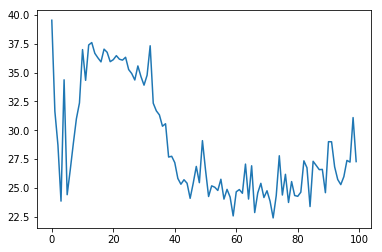

loss on validation set: 27.280200242996216
abcdd
abcdabddcaabcd


In [34]:
RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 32
STATE_SIZE = 256


encoder_decoder = EncoderDecoderNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(encoder_decoder, train_set, val_set, 100)
print(generate(encoder_decoder, 'abcd'))
print(generate(encoder_decoder, 'abcdabcdabcdabcd'))

## Attention

In [38]:
class EncoderDecoderAttentionNetwork(nn.Module):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(EncoderDecoderAttentionNetwork, self).__init__()
        self.num_of_layers = num_of_layers
        self.state_size = state_size
        # the embedding paramaters
        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size)

        # the encoder
        self.enc = nn.LSTM(embeddings_size, state_size, num_of_layers)

        # the decoder
        self.dec = nn.LSTM(state_size, state_size, num_of_layers)

        # the attention
        self.att_w1 = nn.Linear(state_size, state_size, bias=False)
        self.att_w2 = nn.Linear(state_size, state_size)
        self.att_v = nn.Linear(state_size, 1)

        # project the rnn output to a vector of VOCAB_SIZE length
        self.linear = nn.Linear(state_size, VOCAB_SIZE)

    def attention(self, encoder_outputs, decoder_state):
        unnormalized_att = self.att_v(F.tanh(self.att_w1(decoder_state) + self.att_w2(encoder_outputs)))
        att = F.softmax(unnormalized_att.permute(1,0,2), dim=1).permute(1,0,2)
        attended = encoder_outputs.mul(att).sum(0)
        return attended.unsqueeze(0)
    
    def get_rnn_init_state(self, batch_size):
        h0 = torch.zeros(self.num_of_layers, batch_size, self.state_size)
        c0 = torch.zeros(self.num_of_layers, batch_size, self.state_size)
        return h0, c0
    
    def __call__(self, input_string, batch_size):
        embedded = self.embeddings(input_string)
        encoder_outputs, hn = self.enc(embedded, self.get_rnn_init_state(batch_size))

        hiddens = self.get_rnn_init_state(batch_size)
        outputs = []
        for _ in range(len(input_string)):
            encoded = self.attention(encoder_outputs, dec_c)
            output, hiddens = self.dec(encoded, hiddens)
            outputs.append(output)
        logits = self.linear(torch.torch.cat(outputs, 0))

        return F.log_softmax(logits, 2)

In [39]:
att = EncoderDecoderAttentionNetwork(
    RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(att, train_set, val_set)
print(generate(att, 'abcdabcdabcdabcd'))

  0%|          | 0/90000 [00:00<?, ?it/s]


RuntimeError: addmm(): argument 'mat1' (position 1) must be Variable, not torch.FloatTensor